# Power Systems Calculation Package: Myriad

[Intro text here]

In [2]:
# Some graphics processing
import xml.etree.ElementTree as ET
from IPython.display import SVG, display, HTML

import power_system_simulation.graph_processing as pss
import power_system_simulation.optimization as psso
from power_grid_model.utils import json_deserialize, json_serialize

import time
import re
import json
import pandas as pd
    
red = '#f54040'
green = '#86fc53'
blue = '#1cd5ff'

svg_content = ''

def update_style(svg_code, element_id, new_style):
    pattern = f'(<[^>]+id="{element_id}"[^>]+style=")[^"]*(")'
    replacement = f''
    if "e" in element_id:
        replacement = f'\\1stroke:{new_style}\\2'
    elif "v" in element_id:
        replacement = f'\\1fill:{new_style}\\2'
        
    updated_svg_code = re.sub(pattern, replacement, svg_code)
    updated_svg_code = re.sub(f'(<[^>]+id="t{element_id}"[^>]+style=")[^"]*(")', f'\\1fill:{new_style}\\2', updated_svg_code)
        
    return updated_svg_code

def update():
    global svg_content
    style = "<style>svg{width:50px !important;height:50px !important;</style>"
    display(SVG(svg_content), clear=True)

def blink_edges(edge_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for edge in edge_ids:
            svg_content_a=update_style(svg_content_a, f'e{edge}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for edge in edge_ids:
            svg_content_b=update_style(svg_content_b, f'e{edge}', 'gray')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def blink_vertices(vertex_ids, delay, times=5, color='#f54040'):
    for i in range(times):
        svg_content_a = svg_content
        svg_content_b = svg_content
        
        for vertex in vertex_ids:
            svg_content_a=update_style(svg_content_a, f'v{vertex}', color)
        display(SVG(svg_content_a), clear=True)
        time.sleep(delay)
        for vertex in vertex_ids:
            svg_content_b=update_style(svg_content_b, f'v{vertex}', 'white')
        display(SVG(svg_content_b), clear=True)
        time.sleep(delay)
        
def highlight_disabled_edges(gp):
    global svg_content
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#f54040')
            update()
            
def visualizer_init(gp):
    global svg_content
    
    with open('Asset 1.svg', 'r') as file:
        svg_content = file.read()
    
    for edge_index in range(len(gp.edge_ids)):
        if gp.edge_enabled[edge_index] == False:
            svg_content = update_style(svg_content, f'e{gp.edge_ids[edge_index]}', '#303030')
    update()
            
def highlight_edge(edge_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'e{edge_id}', color)
    update()
    
def highlight_vertex(vertex_id, color='#86fc53'):
    global svg_content
    svg_content = update_style(svg_content, f'v{vertex_id}', color)
    update()
    
def visualizer_alternative_edge(gp, edge_id):
    highlight_edge(edge_id, red)
    alternative_edges = gp.find_alternative_edges(edge_id)
    for edge in alternative_edges:
        highlight_edge(edge, color=green)
    
def visualizer_downstream_vertices(gp, edge_id):
    highlight_edge(edge_id, red)
    downstream_vertices = gp.find_downstream_vertices(edge_id)
    for vertex in downstream_vertices:
        highlight_vertex(vertex, color=green)
        
#def visualizer_downstream_vertices_algorithm(gp, edge_id):
    

In [3]:
# Import the dataset
src_dir = "M:/TUE/PowerSystemComputationAndSimulation/input_big_dataset"
ev_dir = "M:/TUE/PowerSystemComputationAndSimulation/output_big_dataset_ev"

meta_data = {}
network_data = {}
active_profile = {}
reactive_profile = {}
ev_active_profile = {}

def load_big_dataset():
    global network_data, meta_data, active_profile, reactive_profile, ev_active_profile
    dir_meta_data_json = src_dir + "/meta_data.json"
    dir_network_json = src_dir + "/input_network_data.json"
    dir_active_profile = src_dir + "/active_power_profile.parquet"
    dir_reactive_profile = src_dir + "/reactive_power_profile.parquet"
    dir_ev_active_profile = src_dir + "/ev_active_power_profile.parquet"

    with open(dir_meta_data_json) as fp:
        data = fp.read()
    meta_data = json.loads(data)

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    active_profile = pd.read_parquet(dir_active_profile)
    reactive_profile = pd.read_parquet(dir_reactive_profile)
    ev_active_profile = pd.read_parquet(dir_ev_active_profile)

# load_big_dataset() Only works if directories are set correctly

## General Overview

This package includes multiple types of functions, some of the important ones are:
- EV Penetration calculations
- Optimal tap position calculation
- Alternative edge searching
- Testing
- Teamwork

***

## EV Penetration

Badr, Arif: [Explain in broad lines how the code works, steps you take to make the calculation]

### Downstream Vertices Algorithm

Milan: [Explain how the algorithm works]

### Downstream Vertices Algorithm Steps

- Remove the input edge from the id_pairs list
- Find the islands
- Check which remaining islands contain the source vertex, the other island is our output

Or in code form:
```python
# Create two islands by seperating the graph at the input edge
edge_list.remove(input_edge)

islands = calculate_islands()

for island in islands:
    if not island.contains(source_vertex):
        return island
```

In [10]:
vertex_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
edge_vertex_id_pairs = [
    (1, 2), (2, 3), (2, 7), (3, 4), (4, 5), (5, 6), (3, 8), (8, 9), (9, 10), (8, 11), (11, 12), (5, 10)
]
edge_enabled = [True, True, True, True, True, True, True, True, True, True, True, False]
source_vertex_id = 1

gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)

pgm = psso.LV_grid(
    network_data, active_profile, reactive_profile, ev_active_profile, meta_data
)


#ev_results_line = pd.read_parquet(ev_dir + "/calculated_output_per_line.parquet")
#ev_results_timestamp = pd.read_parquet(ev_dir + "/calculated_output_per_timestamp.parquet")
#print(ev_results_timestamp)

# visualizer_init(gp)

# visualizer_downstream_vertices(gp, 2)

# time.sleep(1)

                     Max_Voltage_Node  Max_Voltage  Min_Voltage_Node  \
Timestamp                                                              
2025-01-01 00:00:00               1.0     1.073445               0.0   
2025-01-01 00:15:00               1.0     1.077931               0.0   
2025-01-01 00:30:00               1.0     1.071696               0.0   
2025-01-01 00:45:00               1.0     1.075013               0.0   
2025-01-01 01:00:00               1.0     1.074214               0.0   
...                               ...          ...               ...   
2025-01-10 22:45:00               1.0     1.073933               0.0   
2025-01-10 23:00:00               1.0     1.075147               0.0   
2025-01-10 23:15:00               1.0     1.074060               0.0   
2025-01-10 23:30:00               1.0     1.071647               0.0   
2025-01-10 23:45:00               1.0     1.075956               0.0   

                     Min_Voltage  
Timestamp                   

### Applying EV Penetration calculations to a big dataset

Kacper: [Show graphs of node voltages changing when an EV charger turns on? Some other ideas?]

***

## Optimal Tap Position Calculation

Kacper: [Explain stuff]

___

## N-1 Calculation: Alternative grid topology

    Mels: [Explain how the code works]
In this function an edge is disconnected. The goal is to find a table where different alternative edges can be compared. 
For this, a conversion of the input data is required. This way, the functions made in Assignment 1 can be used:
```python 
vertex_ids = [node[0] for node in self.pgm_input["node"]]
edge_ids = [edge[0] for edge in self.pgm_input["line"]]
edge_vertex_id_pairs = [(edge[1], edge[2]) for edge in self.pgm_input["line"]]
edge_enabled = [(edge[3] == 1 and edge[4] == 1) for edge in self.pgm_input["line"]]
source_vertex_id = self.pgm_input["source"][0][1]
``` 
In this assignment we also have transformers. For the purpose of this function, these will be considered as normal edges and will be added to the edge_ids list:
```python 
for transformer in self.pgm_input["transformer"]:
    edge_ids.append(transformer)
```
Now that we have converted the given input data, we can initialize a graph processor object:
```python 
gp = pss.GraphProcessor(
    vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id
)
```
Using the object, we are now able to call: 
```python 
gp.find_alternative_edges(line_id)
```
The function above was written for Assignment 1.
For now we know that this function returns a list of all alternative edges. A more in depth explanation will be given shortly.
A constraint of the power system is that: 
```python
"6. The graph should be fully connected."
```
If we would disable an edge, the function looks for all alternative edges it can enable to have the system be fully connected again, thus following the mentioned contraint of the system. 
The function returns a list. For each alternative edge in that list, N-1 calculation will do as the name suggest, calculations. This is done using functions created in assignment 2. Since these have already been explained. A better way to finish this explanation is to tell what we do with the output of those functions.
We give each alternative edge a row with:
- The alternative Line ID to be connected
- The maximum loading in Watt among all lines and timestamps
- The Line ID of this maximum
- The timestamp of this maximum

Multiple alternative edges means that the table will consist of multiple rows. No alternative edges means that there are no rows in the table and thus having an empty one.

    Milan or Mels: [Explain the algorithm, possibly using the visualization functions Milan wrote]

### Alternative Edge Algorithm Steps

- Get a list of all the disabled edges
- Loop through the list of disabled edges, and one by one enable each disabled edge
- Check if the graph is fully connected and non-circular
- If it is, add it to the list of alternative edges

Or in code form:
```python
alternative_edges = []
disabled_edge_list = []

edge_list.disable_edge(input_edge)

for edge in edge_list:
    if is_disabled(edge) is True:
        disabled_edge_list.append(edge)

for edge in disabled_edge_list:
    # Temporarily enable edge
    edge_list.enable_edge(edge)

    if not graph.isCyclic() and graph.isFullyConnected():
        alternative_edges.append(edge)
```

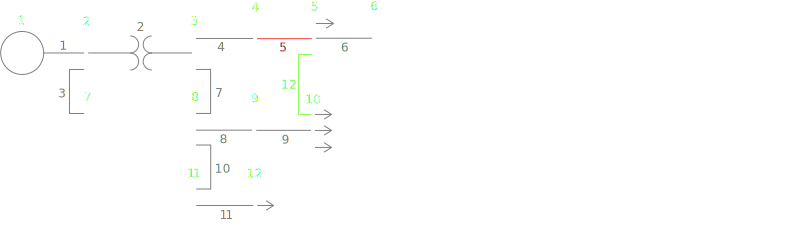

In [ ]:
visualizer_init(gp)

visualizer_alternative_edge(gp, 5)

***

## Testing

Badr or Arif: [Explain how we test the functions, explain how we test errors, and how we make sure the alternative_edge function for example gives the right answer.
                Maybe also explain how we had 2 functions for downstream_vertices and we tested which one was the fastest?]

***

## Teamwork

Someone?: [Explain how we worked together, using github and regular meetings and stuff, maybe planning etc]